In [1]:
import numpy as np
from numpy import array
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import string
import os
from PIL import Image
import glob
from pickle import dump, load
from time import time

from PIL import Image

from keras.preprocessing import sequence
from keras.preprocessing import image
from keras.applications.inception_v3 import preprocess_input
from keras.applications.densenet import DenseNet121

from keras.layers import Input
from keras.layers import Dropout
from keras.layers.core import Dense
from keras.models import Model
from keras import backend as K
#print(dir(keras.applications.densenet.DenseNet121))

from time import time
import pickle
from pickle import dump, load
import glob
import os
from random import shuffle
import importlib
from configparser import ConfigParser

Using TensorFlow backend.


In [2]:
!pip install pydot

In [3]:
first_sent = load(open("KalyanPickle/para.pickle", "rb"))
print('Photos: para.pickle=%d' % len(first_sent))

Photos: para.pickle=3668


In [4]:
first_sent

{'CXR1_1_IM-0001-3001': ['startseq the cardiac silhouette and mediastinum size are within normal limits. there is no pulmonary edema. there is no focal consolidation. there are no xxxx of a pleural effusion. there is no evidence of pneumothorax. endseq'],
 'CXR10_IM-0002-1001': ['startseq the cardiomediastinal silhouette is within normal limits for size and contour. the lungs are normally inflated without evidence of focal airspace disease pleural effusion or pneumothorax. stable calcified granuloma within the right upper lung. no acute bone abnormality. . endseq'],
 'CXR100_IM-0002-1001': ['startseq both lungs are clear and expanded. heart and mediastinum normal. endseq'],
 'CXR1000_IM-0003-1001': ['startseq there is xxxx increased opacity within the right upper lobe with possible mass and associated area of atelectasis or focal consolidation. the cardiac silhouette is within normal limits. xxxx opacity in the left midlung overlying the posterior left 5th rib may represent focal airsp

In [5]:
indication_sent = load(open("KalyanPickle/indication_keys.pickle", "rb"))
print('Photos: indication=%d' % len(indication_sent))

Photos: indication=3668


In [6]:
# convert the loaded descriptions into a vocabulary of words
def to_vocabulary(descriptions):
    # build a list of all description strings
    all_desc = set()
    for key in descriptions.keys():
        [all_desc.update(d.split()) for d in descriptions[key]]
    return all_desc

# summarize vocabulary
vocabulary = to_vocabulary(first_sent)
print('Original Vocabulary Size: %d' % len(vocabulary))

Original Vocabulary Size: 2311


In [7]:
all_indications = set()
for key in indication_sent.keys():
    all_indications.update(indication_sent[key].split())
indicationVocab = all_indications
print('Original Vocabulary Size: %d' % len(indicationVocab))

Original Vocabulary Size: 1572


In [8]:
# Below path contains all the images
images = 'NLMCXR_png/'
# Create a list of all image names in the directory
img = glob.glob(images + '*.png')

In [9]:
train_img_paths = img[:int(len(img)*0.70)]
valid_img_paths = img[int(len(img)*0.70): int(len(img)*0.70 + len(img)*0.20)]
test_img_paths =  img[int(len(img)*0.70 + len(img)*0.20):]

In [10]:
print("No of images for training: ", len(train_img_paths))
print("No of images for validating: ", len(valid_img_paths))
print("No of images for testing: ", len(test_img_paths))

No of images for training:  5229
No of images for validating:  1494
No of images for testing:  747


In [11]:
def get_train_valid_test_data(img):
    img = [item.split("/")[-1] for item in img]
    train_imgs = img[:int(len(img)*0.70)]
    valid_imgs = img[int(len(img)*0.70): int(len(img)*0.70 + len(img)*0.20)]
    test_imgs =  img[int(len(img)*0.70 + len(img)*0.20):]
    return train_imgs, valid_imgs, test_imgs

In [12]:
train_imgs, valid_imgs, test_imgs = get_train_valid_test_data(img)

In [13]:
weights_path = "PavanPickle/best_weights.h5"

In [14]:
class ModelFactory:
    """
    Model facotry for Keras default models
    """

    def __init__(self):
        self.models_ = dict(
            VGG16=dict(
                input_shape=(224, 224, 3),
                module_name="vgg16",
                last_conv_layer="block5_conv3",
            ),
            VGG19=dict(
                input_shape=(224, 224, 3),
                module_name="vgg19",
                last_conv_layer="block5_conv4",
            ),
            DenseNet121=dict(
                input_shape=(224, 224, 3),
                module_name="densenet",
                last_conv_layer="bn",
            ),
            ResNet50=dict(
                input_shape=(224, 224, 3),
                module_name="resnet50",
                last_conv_layer="activation_49",
            ),
            InceptionV3=dict(
                input_shape=(299, 299, 3),
                module_name="inception_v3",
                last_conv_layer="mixed10",
            ),
            InceptionResNetV2=dict(
                input_shape=(299, 299, 3),
                module_name="inception_resnet_v2",
                last_conv_layer="conv_7b_ac",
            ),
            NASNetMobile=dict(
                input_shape=(224, 224, 3),
                module_name="nasnet",
                last_conv_layer="activation_188",
            ),
                        NASNetLarge=dict(
                input_shape=(331, 331, 3),
                module_name="nasnet",
                last_conv_layer="activation_260",
            ),
        )

    def get_last_conv_layer(self, model_name):
        return self.models_[model_name]["last_conv_layer"]

    def get_input_size(self, model_name):
        return self.models_[model_name]["input_shape"][:2]

    def get_model(self, model_name="DenseNet121", use_base_weights=True,
                  weights_path=None, input_shape=None):

        if use_base_weights is True:
            base_weights = "imagenet"
        else:
            base_weights = None

        base_model_class = getattr(
            importlib.import_module(
                f"keras.applications.{self.models_[model_name]['module_name']}"
            ),
            model_name)

        if input_shape is None:
            input_shape = self.models_[model_name]["input_shape"]

        img_input = Input(shape=input_shape)

        base_model = base_model_class(
            include_top=False,
            input_tensor=img_input,
            input_shape=input_shape,
            weights=base_weights,
            pooling="avg")
        x = base_model.output
        predictions = Dense(14, activation="sigmoid", name="predictions")(x)
        model = Model(inputs=img_input, outputs=predictions)

        if weights_path == "":
            weights_path = None
        

        if weights_path is not None:
            print(f"load model weights_path: {weights_path}")
            model.load_weights(weights_path)
        return model

In [15]:
model_factory = ModelFactory()
model = model_factory.get_model(
    use_base_weights=False,
    weights_path=weights_path)
print(model.summary())

Instructions for updating:
Colocations handled automatically by placer.
load model weights_path: PavanPickle/best_weights.h5
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]  

__________________________________________________________________________________________________
conv5_block15_1_conv (Conv2D)   (None, 7, 7, 128)    122880      conv5_block15_0_relu[0][0]       
__________________________________________________________________________________________________
conv5_block15_1_bn (BatchNormal (None, 7, 7, 128)    512         conv5_block15_1_conv[0][0]       
__________________________________________________________________________________________________
conv5_block15_1_relu (Activatio (None, 7, 7, 128)    0           conv5_block15_1_bn[0][0]         
__________________________________________________________________________________________________
conv5_block15_2_conv (Conv2D)   (None, 7, 7, 32)     36864       conv5_block15_1_relu[0][0]       
__________________________________________________________________________________________________
conv5_block15_concat (Concatena (None, 7, 7, 992)    0           conv5_block14_concat[0][0]       
          

In [16]:
def load_image(image_path):
        image = Image.open(image_path)
        image_array = np.asarray(image.convert("RGB"))
        image_array = image_array / 255.
        image_array = np.resize(image_array, (1,224,224,3))
        return image_array

In [17]:
def get_img_encoding(img):
    #img = load_image(train_img_paths[0])
    img = load_image(img)
    get_last_but_one_layer_output = K.function([model.layers[0].input],
                                        [model.layers[-2].output])
    layer_output = get_last_but_one_layer_output([img])
    return layer_output[0].squeeze()

In [18]:
sample_img_encoding = get_img_encoding(img[0])

In [19]:
sample_img_encoding.shape

(1024,)

In [20]:
train_features = load(open("PavanPickle/encoded_train_images.pkl", "rb"))
print('Photos: train=%d' % len(train_features))

Photos: train=5229


In [21]:
train_features

{'CXR1000_IM-0003-1001.png': array([[6.4905726e-05, 1.3562142e-03, 1.3405833e-03, ..., 7.7307308e-01,
         8.1688350e-01, 6.3264632e-01]], dtype=float32),
 'CXR1000_IM-0003-2001.png': array([[6.4905726e-05, 1.3562142e-03, 1.3405833e-03, ..., 7.7307308e-01,
         8.1688350e-01, 6.3264632e-01]], dtype=float32),
 'CXR1000_IM-0003-3001.png': array([[6.4905726e-05, 1.3562142e-03, 1.3405833e-03, ..., 7.7307308e-01,
         8.1688350e-01, 6.3264632e-01]], dtype=float32),
 'CXR1001_IM-0004-1001.png': array([[6.4905726e-05, 1.3562142e-03, 1.3405833e-03, ..., 7.7307308e-01,
         8.1688350e-01, 6.3264632e-01]], dtype=float32),
 'CXR1001_IM-0004-1002.png': array([[6.4905726e-05, 1.3562142e-03, 1.3405833e-03, ..., 7.7307308e-01,
         8.1688350e-01, 6.3264632e-01]], dtype=float32),
 'CXR1002_IM-0004-1001.png': array([[6.4905726e-05, 1.3562142e-03, 1.3405833e-03, ..., 7.7307308e-01,
         8.1688350e-01, 6.3264632e-01]], dtype=float32),
 'CXR1002_IM-0004-2001.png': array([[6.4905726

In [112]:
encoding_test = load(open("PavanPickle/encoded_test_images.pkl", "rb"))
print('Photos: train=%d' % len(encoding_test))

Photos: train=1494


In [113]:
encoding_test

{'CXR3533_IM-1726-2001.png': array([[6.4905726e-05, 1.3562142e-03, 1.3405833e-03, ..., 7.7307308e-01,
         8.1688350e-01, 6.3264632e-01]], dtype=float32),
 'CXR3534_IM-1727-1001.png': array([[6.4905726e-05, 1.3562142e-03, 1.3405833e-03, ..., 7.7307308e-01,
         8.1688350e-01, 6.3264632e-01]], dtype=float32),
 'CXR3534_IM-1727-2001.png': array([[6.4905726e-05, 1.3562142e-03, 1.3405833e-03, ..., 7.7307308e-01,
         8.1688350e-01, 6.3264632e-01]], dtype=float32),
 'CXR3535_IM-1728-0001-0001.png': array([[6.4905726e-05, 1.3562142e-03, 1.3405833e-03, ..., 7.7307308e-01,
         8.1688350e-01, 6.3264632e-01]], dtype=float32),
 'CXR3535_IM-1728-0001-0002.png': array([[6.4905726e-05, 1.3562142e-03, 1.3405833e-03, ..., 7.7307308e-01,
         8.1688350e-01, 6.3264632e-01]], dtype=float32),
 'CXR3536_IM-1729-4004.png': array([[6.4905726e-05, 1.3562142e-03, 1.3405833e-03, ..., 7.7307308e-01,
         8.1688350e-01, 6.3264632e-01]], dtype=float32),
 'CXR3536_IM-1729-5001.png': array([

In [24]:
# Create a list of all the training captions
all_captions = []
for key, val in first_sent.items():
    for cap in val:
        all_captions.append(cap)
len(all_captions)

3668

In [25]:
all_captions

['startseq the cardiac silhouette and mediastinum size are within normal limits. there is no pulmonary edema. there is no focal consolidation. there are no xxxx of a pleural effusion. there is no evidence of pneumothorax. endseq',
 'startseq the cardiomediastinal silhouette is within normal limits for size and contour. the lungs are normally inflated without evidence of focal airspace disease pleural effusion or pneumothorax. stable calcified granuloma within the right upper lung. no acute bone abnormality. . endseq',
 'startseq both lungs are clear and expanded. heart and mediastinum normal. endseq',
 'startseq there is xxxx increased opacity within the right upper lobe with possible mass and associated area of atelectasis or focal consolidation. the cardiac silhouette is within normal limits. xxxx opacity in the left midlung overlying the posterior left 5th rib may represent focal airspace disease. no pleural effusion or pneumothorax. no acute bone abnormality. endseq',
 'startseq in

In [26]:
# Create a list of all the training indications
all_indications = []
for key, val in indication_sent.items():
    all_indications.append(val)
len(all_indications)

3668

In [27]:
len(indication_sent)

3668

In [28]:
# load clean descriptions into memory
def load_clean_descriptions(desc, dataset):
    descriptions = dict()
    for key, val in desc.items():
        image_id, image_desc = key, val
        image_id = image_id+'.png'
        # skip images not in the set
        if image_id in dataset:
            # create list
            if image_id not in descriptions:
                descriptions[image_id] = list()
            # wrap description in tokens
            desc = ''.join(image_desc)
            # store
            descriptions[image_id].append(desc)
    return descriptions

In [29]:
dataset = list()
for img in train_imgs:
    identifier = img[len(images):]
    dataset.append(identifier)

In [30]:
# descriptions
train_descriptions = load_clean_descriptions(first_sent, dataset)
print('Descriptions: train=%d' % len(train_descriptions))

Descriptions: train=2559


In [31]:
# descriptions
train_indications = load_clean_descriptions(indication_sent, dataset)
print('Descriptions: indication=%d' % len(train_indications))

Descriptions: indication=2559


In [32]:
train_descriptions['CXR1_1_IM-0001-3001.png'][0][9:-7]

'the cardiac silhouette and mediastinum size are within normal limits. there is no pulmonary edema. there is no focal consolidation. there are no xxxx of a pleural effusion. there is no evidence of pneumothorax.'

In [33]:
#cleaned_train_descr = dict()
i=0
for key in train_descriptions.keys():
    print(train_descriptions[key][0][9:-7])
    i+=1
    if i==10:
        break

the cardiac silhouette and mediastinum size are within normal limits. there is no pulmonary edema. there is no focal consolidation. there are no xxxx of a pleural effusion. there is no evidence of pneumothorax.
the cardiomediastinal silhouette is within normal limits for size and contour. the lungs are normally inflated without evidence of focal airspace disease pleural effusion or pneumothorax. stable calcified granuloma within the right upper lung. no acute bone abnormality. .
both lungs are clear and expanded. heart and mediastinum normal.
there is xxxx increased opacity within the right upper lobe with possible mass and associated area of atelectasis or focal consolidation. the cardiac silhouette is within normal limits. xxxx opacity in the left midlung overlying the posterior left 5th rib may represent focal airspace disease. no pleural effusion or pneumothorax. no acute bone abnormality.
interstitial markings are diffusely prominent throughout both lungs. heart size is normal. pu

In [34]:
cleaned_train_descr = dict()
for key in train_descriptions.keys():
    cleaned_train_descr[key]=list()
    cleaned_train_descr[key].append('startseq. '+ train_descriptions[key][0][9:-7].strip('.') +'. endseq')

In [35]:
cleaned_train_descr['CXR1_1_IM-0001-3001.png']

['startseq. the cardiac silhouette and mediastinum size are within normal limits. there is no pulmonary edema. there is no focal consolidation. there are no xxxx of a pleural effusion. there is no evidence of pneumothorax. endseq']

In [36]:
# Create a list of all the training captions
all_train_captions = []
for key, val in cleaned_train_descr.items():
    for cap in val:
        all_train_captions.append(cap)
len(all_train_captions)

2559

In [37]:
# Create a list of all the training captions
all_train_indications = []
for key, val in train_indications.items():
    for cap in val:
        all_train_indications.append(cap)
len(all_train_indications)

2559

In [40]:
# Consider only words which occur at least 10 times in the corpus
sent_count_threshold = 1
sent_counts = {}
nsents = 0
for sent in all_train_captions:
    nsents += 1
    for s in sent.split('. '):
        sent_counts[s] = sent_counts.get(s, 0) + 1

sent_vocab = [s.strip('.') for s in sent_counts if sent_counts[s] >= sent_count_threshold and s!='.']
print('preprocessed sentences %d -> %d' % (len(sent_counts), len(sent_vocab)))

preprocessed sentences 4628 -> 4628


In [41]:
sent_vocab[:10]

['startseq',
 'the cardiac silhouette and mediastinum size are within normal limits',
 'there is no pulmonary edema',
 'there is no focal consolidation',
 'there are no xxxx of a pleural effusion',
 'there is no evidence of pneumothorax',
 'endseq',
 'the cardiomediastinal silhouette is within normal limits for size and contour',
 'the lungs are normally inflated without evidence of focal airspace disease pleural effusion or pneumothorax',
 'stable calcified granuloma within the right upper lung']

In [42]:
# Consider only words which occur at least 10 times in the corpus
indication_count_threshold = 1
indication_counts = {}
nsents = 0
for sent in all_train_indications:
    nsents += 1
    for w in sent.split(' '):
        indication_counts[w] = indication_counts.get(w, 0) + 1

indicationVocab = [w for w in indication_counts if indication_counts[w] >= indication_count_threshold]
print('preprocessed words %d -> %d' % (len(indication_counts), len(indicationVocab)))

preprocessed words 1291 -> 1291


In [43]:
ixtosent = {}
senttoix = {}

ix = 1
for s in sent_vocab:
    senttoix[s] = ix
    ixtosent[ix] = s
    ix += 1

In [44]:
sent_vocab_size = len(ixtosent) + 1 # one for appended 0's
sent_vocab_size

4629

In [45]:
ixtoindicationWord = {}
indicationWordtoix = {}

ix = 1
for w in indicationVocab:
    indicationWordtoix[w] = ix
    ixtoindicationWord[ix] = w
    ix += 1

In [46]:
IndicationVocab_size = len(ixtoindicationWord) + 1 # one for appended 0's
IndicationVocab_size

1292

In [47]:
# convert a dictionary of clean descriptions to a list of descriptions
def to_lines(descriptions):
    all_desc = list()
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
    return all_desc

# calculate the length of the description with the most words
def max_length(descriptions):
    lines = to_lines(descriptions)
    return max(len(d.split('. ')) for d in lines)

# determine the maximum sequence length
max_length = max_length(cleaned_train_descr)
print('Description Length: %d' % max_length)

Description Length: 20


In [48]:
for key in cleaned_train_descr.keys():
    train_dsc=cleaned_train_descr[key][0].split('. ')
    if len(train_dsc)==max_length:
        print(key+' -> ')
        for dscr in train_dsc:
            print(dscr)

CXR3278_IM-1559-0001.png -> 
startseq
chest 2 images
heart size is normal
mediastinal contours are maintained
there is a mild pectus excavatum deformity
the lungs are clear of focal infiltrate
there is no evidence for pleural effusion or pneumothorax
no convincing acute bony findings
right shoulder 3 images
there has been xxxx and screw fixation of the midshaft right clavicle
the lateral most screw is fractured
this is age indeterminate as no prior studies are available for comparison
otherwise the surgical xxxx appears intact
the humeral head is seen within the glenoid without evidence for dislocation
no bony fractures are seen
the visualized right ribs appear intact
right clavicle 2 images
no clavicle fracture is seen
once again noted is the surgical fixation xxxx with fracture of the lateral most fixation screw
endseq


In [49]:
all_Indication_desc = list()
for key in train_indications.keys():
    for d in train_indications[key]:
        all_Indication_desc.append(d)

In [50]:
max_Indication_length = max(len(d.split()) for d in all_Indication_desc)
max_Indication_length

40

In [51]:
# data generator, intended to be used in a call to model.fit_generator()
def data_generator(descriptions, photos, indications, senttoix, indicationWordtoix, max_Indication_length,max_length, num_photos_per_batch):
    X1, X2, X3, y = list(), list(), list(), list()
    n=0
    # loop for ever over images
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            # retrieve the photo feature
            photo = photos[key].squeeze()
            for indication in indications[key]:
                indicationSeq = [indicationWordtoix[word] for word in indication.split(' ') if word in indicationWordtoix]
            indicationSeq = pad_sequences([indicationSeq], maxlen=max_Indication_length)[0]
            for desc in desc_list:
                # encode the sequence
                seq = [senttoix[sent] for sent in desc.split('. ') if sent in senttoix]
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=sent_vocab_size)[0]
                    # store
                    X1.append(photo)
                    X2.append(indicationSeq)
                    X3.append(in_seq)
                    y.append(out_seq)
            # yield the batch data
            if n==num_photos_per_batch:
                yield [[array(X1), array(X2), array(X3)], array(y)]
                X1, X2, X3, y = list(), list(), list(), list()
                n=0

In [52]:
sentence_embeddings = load(open("KalyanPickle/sent_embeddings.pickle","rb"))

In [53]:
sentence_embeddings.keys()

dict_keys(['', 'cardiomediastinal silhouette appears within normal limits', 'no pneumothoraces', 'stable unfolding the thoracic aorta', 'clear lungs', 'cannot exclude early pulmonary edema', 'there is focal airspace disease in the right lung base concerning for pneumonia or aspiration', 'no free intraperitoneal air in the diaphragm', 'heart is normal size', 'there is stable right upper lung lucency', 'the lungs appear hyperexpanded consistent with emphysema', 'xxxx right perihilar or midlung density', 'scattered xxxx opacities in the right lung base xxxx representing foci of subsegmental atelectasis with scattered airspace opacities in the medial left lower lobe', 'there is scattered areas of bronchial wall thickening well seen in the left upper lobe', 'ct scan may be informative if patient is at high xxxx for lung cancer', 'there is no focal consolidation pneumothorax or large pleural effusion', 'there is also xxxx patchy opacification identified in the left upper lobe', 'stable chron

In [54]:
print(type(sentence_embeddings['there is stable xxxx tube']))
print('Found %s word vectors.' % len(sentence_embeddings))

<class 'numpy.ndarray'>
Found 6325 word vectors.


In [55]:
sent_embedding_dim = 700

# Get 200-dim dense vector for each of the 10000 words in out vocabulary
embedding_matrix = np.zeros((sent_vocab_size, sent_embedding_dim))

for sent, i in senttoix.items():
    #if i < max_words:
    embedding_vector = sentence_embeddings.get(sent)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros
        embedding_matrix[i] = embedding_vector

In [56]:
from gensim.models import KeyedVectors
word_vectors = KeyedVectors.load_word2vec_format('WordEmbeddings/BioWordVec_PubMed_MIMICIII_d200.vec.bin', binary=True)

In [57]:
embeddings_index = {} # empty dictionary
i = 0
for item in word_vectors.vocab:
    word = item
    coefs = np.asarray(word_vectors.get_vector(word), dtype='float32')
    embeddings_index[word] = coefs
    i+=1
print('Found %s word vectors.' % len(embeddings_index))

Found 16545452 word vectors.


In [58]:
indication_embedding_dim = 200

# Get 200-dim dense vector for each of the 10000 words in out vocabulary
indication_embedding_matrix = np.zeros((IndicationVocab_size, indication_embedding_dim))

for word, i in indicationWordtoix.items():
    #if i < max_words:
    indicationembedding_vector = embeddings_index.get(word)
    if indicationembedding_vector is not None:
        # Words not found in the embedding index will be all zeros
        indication_embedding_matrix[i] = indicationembedding_vector

In [59]:
embedding_matrix.shape

(4629, 700)

In [60]:
indication_embedding_matrix.shape

(1292, 200)

In [61]:
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,\
                         Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization
from keras.optimizers import Adam, RMSprop
from keras.layers.wrappers import Bidirectional
from keras.layers.merge import add
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras import Input, layers
from keras import optimizers
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

In [62]:
IndicationVocab_size

1292

In [63]:
imageFeature = Input(shape=(1024,))
indication = Input(shape=(max_Indication_length,))
indication1 = Embedding(IndicationVocab_size, indication_embedding_dim)(indication)
indication2 = Flatten()(indication1)
imgIndi = keras.layers.concatenate([imageFeature, indication2],axis=1)
fe1 = Dropout(0.5)(imgIndi)
fe2 = Dense(256, activation='relu')(fe1)
findings = Input(shape=(max_length,))
se1 = Embedding(sent_vocab_size, sent_embedding_dim, mask_zero=True)(findings)
se2 = Dropout(0.5)(se1)
# se3 = LSTM(256, return_sequences=True,return_state=True)(se2)
# se4, hs3, cs3 = LSTM(256,return_state=True)(se3)
se3 = Bidirectional(LSTM(256, return_sequences=True))(se2)
se4 = LSTM(256)(se3)
decoder1 = add([fe2, se4])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(sent_vocab_size, activation='softmax')(decoder2)
newModel = Model(inputs=[imageFeature, indication, findings], outputs=outputs)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [64]:
# from keras.utils import plot_model
# plot_model(newModel, to_file='model.png')

In [65]:
# inputs1 = Input(shape=(1024,))
# fe1 = Dropout(0.5)(inputs1)
# fe2 = Dense(256, activation='relu')(fe1)
# inputs2 = Input(shape=(max_length,))
# se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
# se2 = Dropout(0.5)(se1)
# se3 = LSTM(256, return_sequences=True,return_state=True)(se2)
# se4, hs3, cs3 = LSTM(256,return_state=True)(se3)
# decoder1 = add([fe2, se4, cs3])
# decoder2 = Dense(256, activation='relu')(decoder1)
# outputs = Dense(vocab_size, activation='softmax')(decoder2)
# newModel = Model(inputs=[inputs1, inputs2], outputs=outputs)

In [66]:
newModel.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 40)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 40, 200)      258400      input_3[0][0]                    
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 20)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 1024)         0                                            
__________________________________________________________________________________________________
flatten_1 

In [67]:
newModel.layers[1]

In [68]:
newModel.layers[5]

In [69]:
newModel.layers[1].set_weights([indication_embedding_matrix])
newModel.layers[1].trainable = False

In [70]:
newModel.layers[5].set_weights([embedding_matrix])
newModel.layers[5].trainable = False

In [71]:
newModel.compile(loss='categorical_crossentropy', optimizer='adam')

In [72]:
newModel.optimizer.lr = 0.001
epochs = 30
number_pics_per_bath = 6
steps = len(train_descriptions)//number_pics_per_bath

In [73]:
for i in range(epochs):
    generator = data_generator(cleaned_train_descr, train_features,train_indications, senttoix, indicationWordtoix, max_Indication_length,max_length, number_pics_per_bath)
    newModel.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    newModel.save_weights('Sent_Embedding_Model_Weights/model_' + str(i) + '.h5')

Instructions for updating:
Use tf.cast instead.
Epoch 1/1
426/426 [==============================] - 219s 514ms/step - loss: 6.3995
Epoch 1/1
426/426 [==============================] - 196s 460ms/step - loss: 5.0842
Epoch 1/1
426/426 [==============================] - 197s 462ms/step - loss: 4.5333
Epoch 1/1
426/426 [==============================] - 198s 465ms/step - loss: 4.0886
Epoch 1/1
426/426 [==============================] - 198s 464ms/step - loss: 3.6896
Epoch 1/1
426/426 [==============================] - 195s 458ms/step - loss: 3.3199
Epoch 1/1
426/426 [==============================] - 197s 462ms/step - loss: 3.1106
Epoch 1/1
426/426 [==============================] - 196s 460ms/step - loss: 2.8215
Epoch 1/1
426/426 [==============================] - 201s 471ms/step - loss: 2.6565
Epoch 1/1
426/426 [==============================] - 194s 455ms/step - loss: 2.5294
Epoch 1/1
426/426 [==============================] - 193s 452ms/step - loss: 2.3884
Epoch 1/1
426/426 [=========

In [74]:
#newModel.save_weights('NewModel_Weights/model_10.h5')

In [76]:
newModel.load_weights('Sent_Embedding_Model_Weights/model_29.h5')

In [150]:
def greedySearch(photo,indication):
    in_text='startseq'
    for i in range(max_length):
        sequence = [senttoix[s] for s in in_text.split('. ') if s in senttoix]
        sequence = pad_sequences([sequence], maxlen=max_length)
        ind_sequence = [indicationWordtoix[w] for w in indication.split() if w in indicationWordtoix]
        ind_sequence = pad_sequences([ind_sequence], maxlen=max_Indication_length)        
        yhat = newModel.predict([photo,ind_sequence,sequence], verbose=0)
        yhat = np.argmax(yhat)
        sent = ixtosent[yhat]
        in_text += '. ' + sent
        if sent == 'endseq':
            break
    final = in_text.split('. ')
    final = final[1:-1]
    final = '. '.join(final)
    return final

In [131]:
encoding_test.keys()

dict_keys(['CXR3533_IM-1726-2001.png', 'CXR3534_IM-1727-1001.png', 'CXR3534_IM-1727-2001.png', 'CXR3535_IM-1728-0001-0001.png', 'CXR3535_IM-1728-0001-0002.png', 'CXR3536_IM-1729-4004.png', 'CXR3536_IM-1729-5001.png', 'CXR3537_IM-1730-1001.png', 'CXR3537_IM-1730-2001.png', 'CXR3538_IM-1731-1001.png', 'CXR3538_IM-1731-3001.png', 'CXR3539_IM-1731-1001.png', 'CXR3539_IM-1731-3001.png', 'CXR353_IM-1726-1001.png', 'CXR353_IM-1726-2001.png', 'CXR3540_IM-1732-1001.png', 'CXR3540_IM-1732-2001.png', 'CXR3541_IM-1733-0001-0001.png', 'CXR3541_IM-1733-0001-0002.png', 'CXR3542_IM-1734-1001.png', 'CXR3542_IM-1734-2001.png', 'CXR3543_IM-1735-2001.png', 'CXR3543_IM-1735-3001.png', 'CXR3544_IM-1736-1001.png', 'CXR3544_IM-1736-2001.png', 'CXR3545_IM-1737-2002.png', 'CXR3545_IM-1737-3003.png', 'CXR3546_IM-1738-2001.png', 'CXR3546_IM-1738-4004.png', 'CXR3547_IM-1739-1001.png', 'CXR3547_IM-1739-2001.png', 'CXR3548_IM-1739-1001.png', 'CXR3548_IM-1739-2001.png', 'CXR3549_IM-1739-1001-0001.png', 'CXR3549_IM-17

In [132]:
valid_imgs

['NLMCXR_png\\CXR3533_IM-1726-2001.png',
 'NLMCXR_png\\CXR3534_IM-1727-1001.png',
 'NLMCXR_png\\CXR3534_IM-1727-2001.png',
 'NLMCXR_png\\CXR3535_IM-1728-0001-0001.png',
 'NLMCXR_png\\CXR3535_IM-1728-0001-0002.png',
 'NLMCXR_png\\CXR3536_IM-1729-4004.png',
 'NLMCXR_png\\CXR3536_IM-1729-5001.png',
 'NLMCXR_png\\CXR3537_IM-1730-1001.png',
 'NLMCXR_png\\CXR3537_IM-1730-2001.png',
 'NLMCXR_png\\CXR3538_IM-1731-1001.png',
 'NLMCXR_png\\CXR3538_IM-1731-3001.png',
 'NLMCXR_png\\CXR3539_IM-1731-1001.png',
 'NLMCXR_png\\CXR3539_IM-1731-3001.png',
 'NLMCXR_png\\CXR353_IM-1726-1001.png',
 'NLMCXR_png\\CXR353_IM-1726-2001.png',
 'NLMCXR_png\\CXR3540_IM-1732-1001.png',
 'NLMCXR_png\\CXR3540_IM-1732-2001.png',
 'NLMCXR_png\\CXR3541_IM-1733-0001-0001.png',
 'NLMCXR_png\\CXR3541_IM-1733-0001-0002.png',
 'NLMCXR_png\\CXR3542_IM-1734-1001.png',
 'NLMCXR_png\\CXR3542_IM-1734-2001.png',
 'NLMCXR_png\\CXR3543_IM-1735-2001.png',
 'NLMCXR_png\\CXR3543_IM-1735-3001.png',
 'NLMCXR_png\\CXR3544_IM-1736-1001.png'

In [133]:
validation_dataset = list()
for img in encoding_test.keys():
    validation_dataset.append(img)

In [134]:
# descriptions
validation_descriptions = load_clean_descriptions(first_sent, validation_dataset)
print('Descriptions: validation=%d' % len(validation_descriptions))

Descriptions: validation=746


In [135]:
# descriptions
validation_indications = load_clean_descriptions(indication_sent, validation_dataset)
print('Descriptions: indication=%d' % len(validation_indications))

Descriptions: indication=746


In [136]:
validation_descriptions.keys()

dict_keys(['CXR3_IM-1384-1001.png', 'CXR35_IM-1704-1001.png', 'CXR353_IM-1726-1001.png', 'CXR3534_IM-1727-1001.png', 'CXR3535_IM-1728-0001-0001.png', 'CXR3536_IM-1729-4004.png', 'CXR3537_IM-1730-1001.png', 'CXR3538_IM-1731-1001.png', 'CXR3539_IM-1731-1001.png', 'CXR354_IM-1731-1001.png', 'CXR3540_IM-1732-1001.png', 'CXR3541_IM-1733-0001-0001.png', 'CXR3542_IM-1734-1001.png', 'CXR3543_IM-1735-2001.png', 'CXR3544_IM-1736-1001.png', 'CXR3545_IM-1737-2002.png', 'CXR3546_IM-1738-2001.png', 'CXR3547_IM-1739-1001.png', 'CXR3548_IM-1739-1001.png', 'CXR3549_IM-1739-1001-0001.png', 'CXR355_IM-1739-1001.png', 'CXR3550_IM-1740-1001.png', 'CXR3551_IM-1740-1001.png', 'CXR3552_IM-1741-1001.png', 'CXR3553_IM-1741-1001.png', 'CXR3556_IM-1741-1001-0001.png', 'CXR3557_IM-1742-0001-0001.png', 'CXR3559_IM-1744-1001.png', 'CXR356_IM-1744-1001.png', 'CXR3560_IM-1745-1001.png', 'CXR3561_IM-1746-1001.png', 'CXR3562_IM-1747-1001.png', 'CXR3563_IM-1748-2002.png', 'CXR3564_IM-1749-0001-0001.png', 'CXR3565_IM-1750

In [137]:
encoding_test['CXR3_IM-1384-1001.png']

array([[6.4905726e-05, 1.3562142e-03, 1.3405833e-03, ..., 7.7307308e-01,
        8.1688350e-01, 6.3264632e-01]], dtype=float32)

In [138]:
from nltk.translate.bleu_score import sentence_bleu

In [157]:
def get_val_score(pic, weights=(0.25,0.25,0.25,0.25)):
    image = encoding_test[pic].reshape((1,1024))
    candidate = greedySearch(image,validation_indications[pic][0]).split()
    reference = validation_descriptions[pic][0].replace('startseq. ','').replace(' endseq','').split()
    return sentence_bleu(reference,candidate,weights)

In [160]:
def get_val_avg_scores():
    pictures = list(encoding_test.keys())
    total_bleu_4 = 0.0
    total_bleu_3 = 0.0
    total_bleu_2 = 0.0
    total_bleu_1 = 0.0
    cnt = 0
    for pict in pictures:
        if pict in validation_indications.keys():
            total_bleu_4 += get_val_score(pict)
            total_bleu_3 += get_val_score(pict,(0.33,0.33,0.33,0.0))
            total_bleu_2 += get_val_score(pict,(0.5,0.5,0.0,0.0))
            total_bleu_1 += get_val_score(pict,(1.0,0.0,0.0,0.0))
            cnt += 1
    return (total_bleu_4/cnt,total_bleu_3/cnt,total_bleu_2/cnt,total_bleu_1/cnt)

In [161]:
(bleu_4,bleu_3,bleu_2,bleu_1)=get_val_avg_scores()

D:\Anaconda\lib\site-packages\nltk\translate\bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
D:\Anaconda\lib\site-packages\nltk\translate\bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


In [162]:
bleu_4

1.0266071385672675e-232

In [163]:
bleu_3

3.7689205694060005e-205

In [164]:
bleu_2

3.4539659971190515e-156

In [165]:
bleu_1

0.003995287128674231

In [128]:
'CXR3533_IM-1726-2001.png' in validation_indications.keys()

False

In [124]:
'CXR3533_IM-1726-2001.png' in validation_dataset

True

In [123]:
validation_indications.keys()

dict_keys(['CXR3_IM-1384-1001.png', 'CXR35_IM-1704-1001.png', 'CXR353_IM-1726-1001.png', 'CXR3534_IM-1727-1001.png', 'CXR3535_IM-1728-0001-0001.png', 'CXR3536_IM-1729-4004.png', 'CXR3537_IM-1730-1001.png', 'CXR3538_IM-1731-1001.png', 'CXR3539_IM-1731-1001.png', 'CXR354_IM-1731-1001.png', 'CXR3540_IM-1732-1001.png', 'CXR3541_IM-1733-0001-0001.png', 'CXR3542_IM-1734-1001.png', 'CXR3543_IM-1735-2001.png', 'CXR3544_IM-1736-1001.png', 'CXR3545_IM-1737-2002.png', 'CXR3546_IM-1738-2001.png', 'CXR3547_IM-1739-1001.png', 'CXR3548_IM-1739-1001.png', 'CXR3549_IM-1739-1001-0001.png', 'CXR355_IM-1739-1001.png', 'CXR3550_IM-1740-1001.png', 'CXR3551_IM-1740-1001.png', 'CXR3552_IM-1741-1001.png', 'CXR3553_IM-1741-1001.png', 'CXR3556_IM-1741-1001-0001.png', 'CXR3557_IM-1742-0001-0001.png', 'CXR3559_IM-1744-1001.png', 'CXR356_IM-1744-1001.png', 'CXR3560_IM-1745-1001.png', 'CXR3561_IM-1746-1001.png', 'CXR3562_IM-1747-1001.png', 'CXR3563_IM-1748-2002.png', 'CXR3564_IM-1749-0001-0001.png', 'CXR3565_IM-1750

In [149]:
validation_indications['CXR3_IM-1384-1001.png']

['rib pain after a xxxx xxxx xxxx steps this xxxx. pain to r back r elbow and r rib xxxx no previous heart or lung hx non xxxx no hx ca']

OSError: Unable to open file (unable to open file: name = 'NewModel_Weights/model_10.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [140]:
z = 15
z+=1
pic = list(encoding_test.keys())[z]
image = encoding_test[pic]
image.shape

(1, 1024)

In [141]:
cleaned_train_descr

{'CXR1_1_IM-0001-3001.png': ['the cardiac silhouette and mediastinum size are within normal limits. there is no pulmonary edema. there is no focal consolidation. there are no xxxx of a pleural effusion. there is no evidence of pneumothorax.'],
 'CXR10_IM-0002-1001.png': ['the cardiomediastinal silhouette is within normal limits for size and contour. the lungs are normally inflated without evidence of focal airspace disease pleural effusion or pneumothorax. stable calcified granuloma within the right upper lung. no acute bone abnormality. .'],
 'CXR100_IM-0002-1001.png': ['both lungs are clear and expanded. heart and mediastinum normal.'],
 'CXR1000_IM-0003-1001.png': ['there is xxxx increased opacity within the right upper lobe with possible mass and associated area of atelectasis or focal consolidation. the cardiac silhouette is within normal limits. xxxx opacity in the left midlung overlying the posterior left 5th rib may represent focal airspace disease. no pleural effusion or pneum

In [142]:
valid_imgs[41]

'NLMCXR_png\\CXR3551_IM-1740-2001.png'

In [153]:
indication_sent.keys()

dict_keys(['CXR1_1_IM-0001-3001', 'CXR10_IM-0002-1001', 'CXR100_IM-0002-1001', 'CXR1000_IM-0003-1001', 'CXR1001_IM-0004-1001', 'CXR1002_IM-0004-1001', 'CXR1003_IM-0005-2002', 'CXR1004_IM-0005-1001', 'CXR1005_IM-0006-1001', 'CXR1006_IM-0007-1001', 'CXR1007_IM-0008-1001', 'CXR1008_IM-0009-2001', 'CXR1009_IM-0010-1001', 'CXR101_IM-0011-2001', 'CXR1010_IM-0012-1001', 'CXR1011_IM-0013-1001', 'CXR1012_IM-0013-1001', 'CXR1013_IM-0013-1001', 'CXR1014_IM-0013-1001', 'CXR1015_IM-0001-1001', 'CXR1016_IM-0013-1001', 'CXR1017_IM-0013-1001', 'CXR1018_IM-0014-5001', 'CXR1019_IM-0015-1001', 'CXR102_IM-0016-1001', 'CXR1020_IM-0017-1001', 'CXR1021_IM-0017-1001-0001', 'CXR1022_IM-0017-1001', 'CXR1023_IM-0018-1001', 'CXR1024_IM-0019-1001', 'CXR1025_IM-0020-1001', 'CXR1026_IM-0021-2002', 'CXR1027_IM-0021-1001', 'CXR1028_IM-0022-1001', 'CXR1029_IM-0022-1001', 'CXR103_IM-0023-1001', 'CXR1030_IM-0024-1001', 'CXR1032_IM-0026-1001-0001', 'CXR1033_IM-0027-2001', 'CXR1034_IM-0028-1001', 'CXR1035_IM-0028-1001', 'C

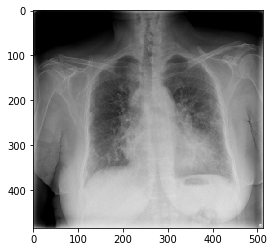

Greedy: heart size normal. lungs are clear. no pneumothorax or pleural effusion


In [197]:
image = get_img_encoding('NLMCXR_png\\CXR1001_IM-0004-1001.png').reshape((1,1024))
x=plt.imread('NLMCXR_png\\CXR1001_IM-0004-1001.png')
plt.imshow(x)
plt.show()
indic=indication_sent['CXR1001_IM-0004-1001']
indc_sent=[indicationWordtoix[ind] for ind in indic.split()]
#print(image)
print("Greedy:",greedySearch(image,pad_sequences([indc_sent],maxlen=max_Indication_length)))

In [198]:
first_sent['CXR1001_IM-0004-1001']

['startseq interstitial markings are diffusely prominent throughout both lungs. heart size is normal. pulmonary xxxx normal. endseq']

CXR3548_IM-1739-1001.png


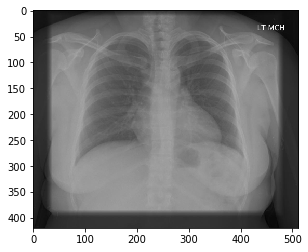

Greedy: cardiac and mediastinal contours are within normal limits. the lungs are clear. bony structures are intact


In [203]:
z = 30
z+=1
pic = list(encoding_test.keys())[z]
print(pic)
image = encoding_test[pic].reshape((1,1024))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
indic=indication_sent[pic.split('.')[0]]
indc_sent=[indicationWordtoix[ind] for ind in indic.split()]
print("Greedy:",greedySearch(image,pad_sequences([indc_sent],maxlen=max_Indication_length)))

In [204]:
first_sent[pic.split('.')[0]]

['startseq the heart is normal in size. the pulmonary vascularity is within normal limits in appearance. no focal air space opacities. no pleural effusions or pneumothorax. no acute bony abnormalities. endseq']

In [199]:
first_sent['CXR1_1_IM-0001-3001']

['startseq the cardiac silhouette and mediastinum size are within normal limits. there is no pulmonary edema. there is no focal consolidation. there are no xxxx of a pleural effusion. there is no evidence of pneumothorax. endseq']

In [82]:
first_sent['CXR3533_IM-1726-1001']

['startseq heart size mediastinal contour and pulmonary vascularity are within normal limits. there is bilateral hyperinflation without focal consolidation pneumothorax or pleural effusion. visualized osseous structures appear intact. endseq']

In [ ]:
def beam_search_predictions(photo, beam_index = 3):
    start = [wordtoix["startseq"]]
    
    # start_word[0][0] = index of the starting word
    # start_word[0][1] = probability of the word predicted
    start_word = [[start, 0.0]]
    
    while len(start_word[0][0]) < max_length:
        temp = []
        for s in start_word:
            par_caps = sequence.pad_sequences([s[0]], maxlen=max_length, padding='post')
            e = encoding_test[photo[len(images):]]
            #preds = model.predict([np.array([e]), np.array(par_caps)])
            preds = newModel.predict([np.array([e]),np.array(par_caps)], verbose=0)
            
            # Getting the top <beam_index>(n) predictions
            word_preds = np.argsort(preds[0])[-beam_index:]
            
            # creating a new list so as to put them via the model again
            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
                prob += preds[0][w]
                temp.append([next_cap, prob])
                    
        start_word = temp
        # Sorting according to the probabilities
        start_word = sorted(start_word, reverse=False, key=lambda l: l[1])
        # Getting the top words
        start_word = start_word[-beam_index:]
    
    start_word = start_word[-1][0]
    intermediate_caption = [ixtoword[i] for i in start_word]

    final_caption = []
    
    for i in intermediate_caption:
        if i != 'endseq':
            final_caption.append(i)
        else:
            break
    
    final_caption = ' '.join(final_caption[1:])
    return final_caption

In [ ]:
z = 15
z+=1
pic = list(encoding_test.keys())[z]
image = encoding_test[pic]


In [ ]:
print ('Beam Search, k=10:', beam_search_predictions(image, beam_index=10))

In [147]:
word_vectors.get_vector('startseq')

KeyError: "word 'startseq' not in vocabulary"

In [ ]:
imageFtr = Input(shape=(1024,))
indic = Input(shape=(max_Indication_length,))
indic1 = Embedding(IndicationVocab_size, indication_embedding_dim)(indic)
indic2 = Flatten()(indic1)
img_Indi = keras.layers.concatenate([imageFtr, indic2],axis=1)
fe_1 = Dropout(0.5)(img_Indi)
fe_2 = Dense(256, activation='relu')(fe_1)
fndngs = Input(shape=(max_length,))
se_1 = Embedding(sent_vocab_size, sent_embedding_dim, mask_zero=True)(fndngs)
se_2 = Dropout(0.5)(se_1)
se_3 = LSTM(256, return_sequences=True,return_state=True)(se_2)
se_4, hs_3, cs3 = LSTM(256,return_state=True)(se_3)
#se3 = Bidirectional(LSTM(256, return_sequences=True))(se2)
#se4 = LSTM(256)(se3)
decoder_1 = add([fe_2, se_4, hs_3])
decoder_2 = Dense(256, activation='relu')(decoder_1)
outputs_1 = Dense(sent_vocab_size, activation='softmax')(decoder_2)
newModel_1 = Model(inputs=[imageFtr, indic, fndngs], outputs=outputs_1)